<a href="https://colab.research.google.com/github/gentleheart91/Web-based-data-Project/blob/main/LMs_for_EHR_PracticalSession.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Models for EHR: Practical Session

![ISPED](https://www.isped.u-bordeaux.fr/Portals/0/ISPED-UBX_2019CJMN.jpg?ver=IgWweaT8nsEypRFlN6bn5A%3d%3d)

**Author:** Ariel Guerra-Adames \
**Adapted From Marteen Grootendorst's "Hands-On Large Language Models"** \
**Date:** November 29th \
**Course:** Language Models for EHR - UE Electronic Health Data \
**Institution:** ISPED - Université de Bordeaux \
**Description:** This notebook introduces the basics of language modeling for Electronic Health Records (EHR).

---

💡 **NOTE**: We will want to use a GPU to run this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

In [ ]:
# %%capture
!pip install transformers>=4.40.1 accelerate>=0.27.2 unsloth bitsandbytes umap-learn sentence-transformers>=3.0.1 gensim>=4.3.2 scikit-learn>=1.5.0 accelerate>=0.31.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


# Loading Pre-Trained Language Models from Hugging Face

The first step is to load our model onto the GPU for faster inference. Note that we load the model and tokenizer separately (although that isn't always necessary). We'll be using a nice library called Unsloth which allows us to use quantized versions for faster inference.

For the choice of model, we'll be using a fine-tuned version of Llama 3.1 called AlpaCare-MedInstruct, which has also been fine-tuned for instruction following.

Link to the paper: https://arxiv.org/abs/2310.14558

Link to the HuggingFace repo: https://huggingface.co/Svngoku/Llama-3.1-8B-AlpaCare-MedInstruct-GGUF

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer
from unsloth import FastLanguageModel

model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "Svngoku/Llama-3.1-8B-AlpaCare-MedInstruct",
        max_seq_length = 1024,
        dtype = None,
        load_in_4bit = True,
)
FastLanguageModel.for_inference(model)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.11.11: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Unsloth 2024.11.11 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor

Here, we'll make a function to generate answers based on an instruction and an input. this is an example of zero shot model

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

def generate_medical_answer(input: str = "", instruction: str = ""):
  inputs = tokenizer(
  [
      alpaca_prompt.format(
          instruction,
          input,
          "",
      )
  ], return_tensors = "pt").to("cuda")
  text_streamer = TextStreamer(tokenizer)

  output = model.generate(**inputs, max_new_tokens=1024)

  generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

  response_start = generated_text.find("### Response:") + len("### Response:")
  response = generated_text[response_start:].strip()

  return response

Let's give it an Ophtalmology sample from mtsamples.com

In [ ]:
generate_medical_answer(
  instruction = "In one or two words, like 'gynecology' or 'odontology', tell me what the medical speciality of this clinical note is:",
  input="A trabeculectomy was done and then the tube was threaded through the trabeculectomy site. The tube was sutured in place with a multi-wrapped 8-0 nylon suture. The scleral flap was then sutured in place with two 10-0 nylon sutures. The knots were trimmed, rotated and buried. A scleral patch was then placed of an appropriate size over the two. It was sutured in place with interrupted 8-0 nylon sutures. The knots were trimmed. The overlying conjunctiva was then closed with a running 8-0 Vicryl suture with a BV needle. The anterior chamber was filled with Viscoat to keep it deep as the eye was somewhat soft. A good flow was established with irrigation into the anterior chamber. Homatropine, Econopred, and Vigamox drops were placed into the eye. A patch and shield were placed over the eye after removing the draping and the speculum."
)

'The medical specialty of this clinical note is ophthalmology.'

In [ ]:
Lung, wedge biopsy right lower lobe and resection right upper lobe. Lymph node, biopsy level 2 and 4 and biopsy level 7 subcarinal. PET scan demonstrated a mass in the right upper lobe and also a mass in the right lower lobe, which were also identified by CT scan.

In [ ]:
generate_medical_answer(
  instruction = "In one or two words, like 'gynecology' or 'odontology', tell me what the medical speciality of this clinical note is:",
  input="Lung, wedge biopsy right lower lobe and resection right upper lobe. Lymph node, biopsy level 2 and 4 and biopsy level 7 subcarinal. PET scan demonstrated a mass in the right upper lobe and also a mass in the right lower lobe, which were also identified by CT scan.."
)

'The medical specialty of this clinical note is pulmonology.'

Correct! Now, try with another specialization and see if it correctly classifies the specialization. Again, I recommend you to choose one from MTSamples.com

In [ ]:
generate_medical_answer(
  instruction = "In one or two words, like 'gynecology' or 'odontology', tell me what the medical speciality of this clinical note is:",
  input=""
)

Now let's take a look at how the model really interprets the inputs we give it. First, let's make a function which just prints the tokens.

In [ ]:
def print_tokens(input: str = "", instruction: str = ""):
  inputs = tokenizer(
  [
      alpaca_prompt.format(
          instruction,
          input,
          "",
      )
  ], return_tensors = "pt").to("cuda")

  tokens = inputs['input_ids'][0]

  return tokens

tokens = print_tokens(
  instruction = "In one or two words, like 'gynecology' or 'odontology', tell me what the medical speciality of this clinical note is:",
  input="A trabeculectomy was done and then the tube was threaded through the trabeculectomy site."
)

print(tokens)

tensor([128000,  39314,    374,    459,   7754,    430,  16964,    264,   3465,
            11,  35526,    449,    459,   1988,    430,   5825,   4726,   2317,
            13,   9842,    264,   2077,    430,  36001,  45695,    279,   1715,
           382,  14711,  30151,    512,    644,    832,    477,   1403,   4339,
            11,   1093,    364,     70,  75030,   2508,      6,    477,    364,
           347,  63333,    518,   3371,    757,   1148,    279,   6593,   3361,
           488,    315,    420,  14830,   5296,    374,   1473,  14711,   5688,
           512,     32,  18062,    762,     84,    772,   5650,    574,   2884,
           323,   1243,    279,  14019,    574,  67887,   1555,    279,  18062,
           762,     84,    772,   5650,   2816,    382,  14711,   6075,    512],
       device='cuda:0')


Now, let's decode these tokens and take a look at how the tokenizer separates words.

In [ ]:
for id in tokens:
   print(tokenizer.decode(id), end=" ")

<|begin_of_text|> Below  is  an  instruction  that  describes  a  task ,  paired  with  an  input  that  provides  further  context .  Write  a  response  that  appropriately  completes  the  request .

 ###  Instruction :
 In  one  or  two  words ,  like  ' g ynec ology '  or  ' od ontology ',  tell  me  what  the  medical  special ity  of  this  clinical  note  is :

 ###  Input :
 A  trab ec u lect omy  was  done  and  then  the  tube  was  threaded  through  the  trab ec u lect omy  site .

 ###  Response :
 

Interesting! It seems to know that terminations like '-ology' or '-omy' are individual particles. Now, let's compare other tokenizers which have not been fine-tuned on medical data. For this, let's create another function which performs the tokenization with the specified model, and colors separate tokens.

In [ ]:
colors_list = [
    '102;194;165', '252;141;98', '141;160;203',
    '231;138;195', '166;216;84', '255;217;47'
]

def show_tokens(sentence, tokenizer_name):
    tokenizer_n = AutoTokenizer.from_pretrained(tokenizer_name)
    token_ids_n = tokenizer_n(sentence).input_ids
    for idx, t in enumerate(token_ids_n):
        print(
            f'\x1b[0;30;48;2;{colors_list[idx % len(colors_list)]}m' +
            tokenizer_n.decode(t) +
            '\x1b[0m',
            end=' '
        )

text = "In one or two words, like 'gynecology' or 'odontology', tell me what the medical speciality of this clinical note is: A trabeculectomy was done and then the tube was threaded through the trabeculectomy site."

Let's try GatorTron-based, a medical encoder-only model.

In [ ]:
show_tokens(text, "UFNLP/gatortron-base")

config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/379k [00:00<?, ?B/s]

[CLS] in one or two words , like ' gynec ##ology ' or ' odont ##ology ' , tell me what the medical special ##ity of this clinical note is : a trabec ##ulectomy was done and then the tube was threaded through the trabec ##ulectomy site . [SEP] 

And now, let's try a general-language encoder-only model like BERT.

In [ ]:
show_tokens(text, "bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

[CLS] In one or two words , like ' g ##yne ##cology ' or ' o ##don ##tology ' , tell me what the medical special ##ity of this clinical note is : A t ##rab ##ec ##ule ##ct ##omy was done and then the tube was thread ##ed through the t ##rab ##ec ##ule ##ct ##omy site . [SEP] 

Huh, very different tokens. Why is that?

# Contextualized Word Embeddings From a Language Model

Now you know how tokenization works. Once tokens are produced, LLMs 'projects' them into a higher-dimensional space which contains information about the context of each word. This is what we call embeddings. Let's try to see what those look like.

In [ ]:
from transformers import AutoModel

tokenizer = AutoTokenizer.from_pretrained("UFNLP/gatortron-base")
model = AutoModel.from_pretrained("UFNLP/gatortron-base")

pytorch_model.bin:   0%|          | 0.00/713M [00:00<?, ?B/s]

In [ ]:
#Tokenizing the sentence
tokens = tokenizer('A trabeculectomy was done', return_tensors='pt')
for ids in tokens['input_ids'][0]:
  print(tokenizer.decode(ids), end=" ")

#After processing the tokens, the model outputs a dense representation or "word embeddings" of the tokens
output = model(**tokens)[0]

output.shape

[CLS] a trabec ##ulectomy was done [SEP] 

torch.Size([1, 7, 1024])

OK! So a 7x1024 tensor: each token is 1024 dimensions corresponding to the last linear layer of the gatortron model. We can take a look at what that looks like on the inside

In [ ]:
output

# Text Embeddings (For Sentences and Whole Documents)


Word embeddings are cool and all but, what if we could embed entire sentences (or documents), into a single dense representation? That's what Sentence Transformers are for!

Sentence Transformers are like normal transformer models, but their training is a bit different: we use siamese networks to learn how to best represent all the words in the documents into a single vector.

Here we will use a version of BioBERT, which has been fine-tuned to produce sentence-level embeddings.

In [ ]:
from sentence_transformers import SentenceTransformer

# Load medical SentenceTransformer model
model = SentenceTransformer('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb')

# Convert sentence to sentence embeddings
vector = model.encode("A trabeculectomy was done and then the tube was threaded through the trabeculectomy site.")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Let's see how that looks like: 768 size vectors

In [ ]:
vector.shape

(768,)

Nice. This vector representation is full of information that we can use. Let's see, in this higher-dimensional space, if sentences from the same specialization are close to each other.

For this, we will use **UMAP** (Uniform Manifold Approximation and Projection for Dimension Reduction), a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. Think of it as **non-linear PCA.**

First, let's import the mtsamples dataset as a dataframe (I put the file on Renater for now, you can find it later in https://www.kaggle.com/datasets/atharvakaushik/mtsamples)

In [ ]:
import requests

url = "https://filesender.renater.fr/download.php?token=2854d7bf-02d2-4c55-8087-3cbd353a6560&files_ids=46137050"
response = requests.get(url)

with open("mtsamples.csv", "wb") as f:
    f.write(response.content)

Reading it as a dataframe

In [ ]:
import pandas as pd

mtsamples = pd.read_csv('mtsamples.csv')

Let's take a quick look at the data to make sure it was imported correctly

In [ ]:
mtsamples.head(10)

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
5,5,Morbid obesity. Laparoscopic antecolic anteg...,Bariatrics,Laparoscopic Gastric Bypass,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...","bariatrics, gastric bypass, eea anastomosis, r..."
6,6,"Liposuction of the supraumbilical abdomen, re...",Bariatrics,Liposuction,"PREOPERATIVE DIAGNOSES:,1. Deformity, right b...","bariatrics, breast reconstruction, excess, lma..."
7,7,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram..."
8,8,Suction-assisted lipectomy - lipodystrophy of...,Bariatrics,Lipectomy - Abdomen/Thighs,"PREOPERATIVE DIAGNOSIS: , Lipodystrophy of the...","bariatrics, lipodystrophy, abd pads, suction-a..."
9,9,Echocardiogram and Doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,..."


Let's keep only two medical specialities that are quite distinct from each other

In [ ]:
desired_specialties = [' Cardiovascular / Pulmonary', ' Gastroenterology']
mtsamples_filtered = mtsamples[mtsamples['medical_specialty'].isin(desired_specialties)]

Now, try to create sentence embeddings for all samples using the model we previously loaded. Tip: use *model.encode()* alwas cast the trancription as a string

In [ ]:
mtsamples_filtered['transcription'] = mtsamples_filtered['transcription'].astype(str)

###Your turn
# Convert sentence to sentence embeddings
mtsamples_filtered['embedings'] = mtsamples_filtered['transcription'].apply(lambda x:model.encode(x))

<ipython-input-23-8d7bf00eae8b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mtsamples_filtered['transcription'] = mtsamples_filtered['transcription'].astype(str)
<ipython-input-23-8d7bf00eae8b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mtsamples_filtered['embedings'] = mtsamples_filtered['transcription'].apply(lambda x:model.encode(x))


Now, let's import UMAP, add our created embeddings, and obtain a 2D representation of our data.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


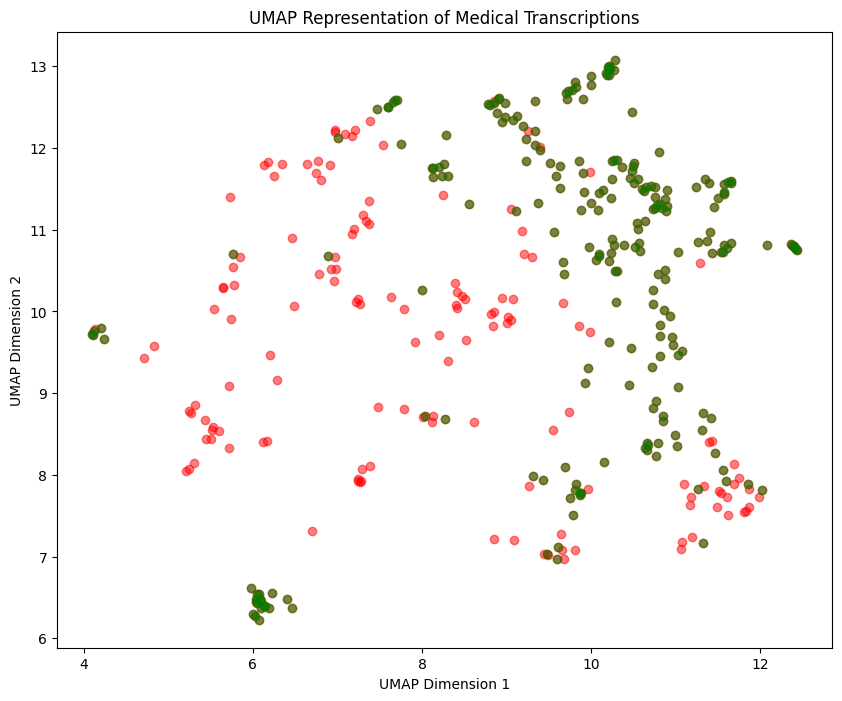

In [ ]:
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(mtsamples_filtered['embedings'].tolist())

plt.figure(figsize=(10, 8))
colors = {' Cardiovascular / Pulmonary': 'red', ' Gastroenterology': 'green'}

for category, color in colors.items():
    subset = mtsamples_filtered[mtsamples_filtered['medical_specialty'] == category]

    subset = subset.reset_index(drop=True)

    for index, row in subset.iterrows():
        plt.scatter(embeddings_2d[index, 0], embeddings_2d[index, 1], label=category, c=color, alpha=0.5)

plt.title('UMAP Representation of Medical Transcriptions')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

You should see that the green dots (Gastroenterology) are grouped mostly in one side of the representation, while the red dots (Cardiovascular) are on the other side.

# Text Classification with Sentence Embeddings

Now that we've seen that sentence embeddings can be used to project entire documents into a higher dimensional space which contains contextual information, let's try to see how we can use them to make a medical specialization classifier. Note that you can do this with almost any type of EHR data, since even tabular data can be interpreted as text.

First, let's re-import the libraries we need.

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

Let's take five distinct specializations wich are not too similar between them

In [ ]:
desired_specialties = [' Cardiovascular / Pulmonary', ' Gastroenterology', ' Obstetrics / Gynecology', ' ENT - Otolaryngology', ' Hematology - Oncology']
mtsamples_filtered = mtsamples[mtsamples['medical_specialty'].isin(desired_specialties)]

Once again, let's make sentence embeddings with the documents

In [ ]:
mtsamples_filtered['transcription'] = mtsamples_filtered['transcription'].astype(str)

##Complete here



# Convert sentence to sentence embeddings
mtsamples_filtered['embedings'] = mtsamples_filtered['transcription'].apply(lambda x:model.encode(x))

<ipython-input-28-050dd063ab4c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mtsamples_filtered['transcription'] = mtsamples_filtered['transcription'].astype(str)
<ipython-input-28-050dd063ab4c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mtsamples_filtered['embedings'] = mtsamples_filtered['transcription'].apply(lambda x:model.encode(x))


## Final Task:

With what you have seen so far, your task now is to train your favorite classifier (Random Forest, XGBoost, Variational Autoencoder with a Non-Gaussian Prior, etc.) on the previously prepared embeddings as your training data (X) with the objective of predicting the corresponding label, in this case the 'medical_specialty' column. At the end, evaluate your model(s) and try to obtain standard classification metrics.

I recommend you to:


1.   Convert your 'embeddings' column to a list or a Pandas series
2.   Encode the labels ('medical_speciality' column) as integers, possibly using the LabelEncoder() function from Scikit-Learn
3.   Split your data into train and test partitions, possibly using the train_test_split() function from Scikit-Learn
4.   Train your favorite model (again, X -> Embeddings, Y -> Encoded labels)
5.   Run inference on the test partition.
6.   Evaluate, possibly using the classification_report function from Scikit-Learn


Best three classifier models get some money.

In [ ]:
mtsamples_filtered

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,embedings
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...","[0.1447044, 0.8862476, 0.48968095, 0.24028096,..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...","[-0.38046256, 0.9506563, 0.17747825, 0.0535954..."
7,7,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram...","[-0.2755798, 0.5176677, 0.6936694, -0.06959781..."
9,9,Echocardiogram and Doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,...","[-0.016542327, 0.6013333, 0.53182495, 0.144695..."
11,11,"Normal left ventricle, moderate biatrial enla...",Cardiovascular / Pulmonary,2-D Doppler,"2-D STUDY,1. Mild aortic stenosis, widely calc...","cardiovascular / pulmonary, 2-d study, doppler...","[0.07930479, 0.80356187, 0.57751787, 0.5584978..."
...,...,...,...,...,...,...,...
4972,4972,Adenosine with nuclear scan as the patient un...,Cardiovascular / Pulmonary,Adenosine Nuclear Scan,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...","cardiovascular / pulmonary, adenosine nuclear ...","[0.019326197, 0.3309318, 0.5495414, -0.1618461..."
4973,4973,Patient presents with a chief complaint of ch...,Cardiovascular / Pulmonary,Acute Inferior Myocardial Infarction,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...",NaN,"[0.13890755, 0.5139667, 0.30905265, -0.2076033..."
4974,4974,Patient had a recurrent left arm pain after h...,Cardiovascular / Pulmonary,Angina - Consult,"HISTORY OF PRESENT ILLNESS: , The patient is a...",NaN,"[-0.1636805, 0.36793903, -0.040494643, 0.64604..."
4975,4975,Patient had a markedly abnormal stress test w...,Cardiovascular / Pulmonary,Abnormal Stress Test,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...","cardiovascular / pulmonary, standard bruce, ni...","[0.17338066, 0.5129944, 0.3806612, -0.10892469..."


In [ ]:
X = mtsamples_filtered['embedings'].tolist()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(mtsamples_filtered['medical_specialty'])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


190

In [ ]:
clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:59:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.84


In [ ]:
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.85      0.93      0.89        76
       ENT - Otolaryngology       0.87      0.72      0.79        18
           Gastroenterology       0.92      0.87      0.89        52
      Hematology - Oncology       0.47      0.60      0.53        15
    Obstetrics / Gynecology       0.96      0.76      0.85        29

                   accuracy                           0.84       190
                  macro avg       0.81      0.78      0.79       190
               weighted avg       0.85      0.84      0.84       190



## Also (just in case):


**Precision:** Measures accuracy of positive predictions

```
Precision = True Positives / (True Positives + False Positives)
```

"When model predicts positive, how often is it correct?"
\

**Recall:** Measures ability to find all positive cases

```
Recall = True Positives / (True Positives + False Negatives)
```

"What proportion of actual positives was identified correctly?"
\

**F1-Score:** Harmonic mean of precision and recall


```
F1 = 2 × (Precision × Recall) / (Precision + Recall)
```

Balances precision and recall in a single score